In [1]:
import anndata
import seaborn as sns
import pandas as pd
import scanpy as sc
import numpy as np

sc.settings.set_figure_params(dpi=80)

Step one - load Chenqu's object and write out the cell names to guide conga input prep.

In [2]:
adata = sc.read("/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/write/DP_cell_adata_pseudotime_with_gex_11012023.h5ad")
with open("barcodes.txt", "w") as fid:
    fid.writelines([i+"\n" for i in adata.obs_names])

What happened here is I downloaded and compiled conga on openstack, and then ran the script `prep.sh` stored in this directory to create an input file for it. The input file is a subset of the cellranger `all_contig_annotations.csv` file, filtering to just the cells that actually appear in Chenqu's object. The barcode and contig name fields then have the appropriate GEX ID prepended, matching Chenqu's nomenclature in the object. The relationship between GEX and VDJ ID is guided via a `meta.csv` file also stored in the folder.

Once the input file was created, conga was ran via `python3 setup_10x_for_conga.py --filtered_contig_annotations_csvfile conga.csv --organism human`, producing messages stored in `conga-run-printout`

Two files were copied over for analysis:
- `conga_tcrdist_clones_AB.dist_50_kpcs`, the PC coordinates for the identified clonotypes; renamed to `conga-pcs.tsv`
- `conga_tcrdist_clones.tsv.barcode_mapping.tsv`, the actual barcodes that make up the clonotypes; renamed to `conga-cells.tsv`

Shave off a surplus column from the PC file, and set the index to be the clonotype. Time for the cell assignments!

In [3]:
conga = pd.read_table("conga-pcs.tsv", sep=" ", header=None).iloc[:,1:].set_index(1)
conga

,2,3,4,5,6,7,8,9,10,11,...,42,43,44,45,46,47,48,49,50,51
1,,,,,,,,,,,,,,,,,,,,,
clonotype1218,-0.070763,-0.017894,-0.110333,0.151353,-0.061635,-0.059806,-0.060542,-0.069905,-0.122416,-0.004782,...,-0.004131,-0.063498,-0.003384,-0.006139,0.063270,-0.071902,-0.026007,0.012469,-0.025485,0.042574
clonotype1314,-0.135726,-0.038496,0.134072,-0.044949,-0.147527,0.023166,-0.006773,-0.040152,-0.026281,-0.060165,...,-0.017975,0.012320,0.100833,-0.015783,-0.022903,0.046629,0.019822,0.077198,0.002327,-0.000988
clonotype1326,-0.139686,-0.132983,0.024689,0.039141,0.067737,0.089548,-0.016768,0.032418,0.114884,0.090714,...,-0.025789,0.013250,0.075503,0.042064,0.045956,-0.036009,0.077102,-0.028271,-0.007321,0.001611
clonotype1348,-0.034133,0.032096,0.045944,0.014502,-0.033282,-0.076612,0.148018,0.014944,-0.091119,-0.009621,...,0.025422,-0.099377,-0.057620,-0.002663,0.103026,-0.070218,0.001249,-0.034956,0.043736,0.008778
clonotype1365,-0.076124,0.062027,0.028308,0.161516,-0.004889,0.001690,0.051095,0.001711,0.011357,-0.017036,...,0.050350,-0.096314,-0.104665,0.054083,0.041241,0.046793,0.005760,0.018556,-0.016976,-0.009822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
clonotype864,-0.144722,-0.125822,0.046433,0.036432,0.079496,0.122248,-0.021606,0.099071,0.142659,0.081201,...,-0.031087,0.038454,-0.027077,0.006945,0.026121,-0.039339,0.028406,0.014912,-0.021303,-0.031786
clonotype869,-0.057117,-0.123679,0.014944,0.019538,-0.160646,0.071145,0.097445,0.126523,0.090113,0.005556,...,-0.002556,0.064177,0.073932,-0.039087,-0.016100,0.025723,0.010427,0.024193,-0.035054,-0.030364
clonotype896,-0.124533,-0.044487,0.121780,-0.004172,-0.041974,-0.068979,0.010690,-0.038946,-0.114757,0.084734,...,-0.016754,0.050596,0.010538,-0.041371,-0.001242,0.049012,0.027444,-0.002680,0.027955,-0.028517


Of note, most of these are singleton assignments. Occasionally there will be a pair. I took the first one for the purposes of digging up the annotation, which should be firmly good enough.

In [4]:
cells = pd.read_table("conga-cells.tsv", index_col=0)
#oh also there are -1s at the end of cell barcodes. kick those
cells['barcodes'] = [i.split(",")[0].replace("-1","") for i in cells['barcodes']]
cells

,barcodes
clone_id,
clonotype1218,FCAImmP7803035-CATATGGCAGCCTGTG
clonotype1314,FCAImmP7803034-TGCTGCTTCTGTTTGT
clonotype1326,FCAImmP7292034-GTGGGTCAGCACACAG
clonotype1348,FCAImmP7803034-CTCAGAAAGTCTCCTC
clonotype1365,FCAImmP7803035-AGTGAGGGTAAACACA
...,...
clonotype864,FCAImmP7803035-CCAATCCCATCTCGCT
clonotype869,FCAImmP7803035-GCCTCTAAGAATAGGG
clonotype896,FCA_gut8015061-ATTATCCCACGCGAAA


Is our index the same?

In [5]:
np.all(cells.index == conga.index)

True

It is! Jolly good! Rename the clonotypes to the barcodes.

In [6]:
conga.index = cells['barcodes']
conga

,2,3,4,5,6,7,8,9,10,11,...,42,43,44,45,46,47,48,49,50,51
barcodes,,,,,,,,,,,,,,,,,,,,,
FCAImmP7803035-CATATGGCAGCCTGTG,-0.070763,-0.017894,-0.110333,0.151353,-0.061635,-0.059806,-0.060542,-0.069905,-0.122416,-0.004782,...,-0.004131,-0.063498,-0.003384,-0.006139,0.063270,-0.071902,-0.026007,0.012469,-0.025485,0.042574
FCAImmP7803034-TGCTGCTTCTGTTTGT,-0.135726,-0.038496,0.134072,-0.044949,-0.147527,0.023166,-0.006773,-0.040152,-0.026281,-0.060165,...,-0.017975,0.012320,0.100833,-0.015783,-0.022903,0.046629,0.019822,0.077198,0.002327,-0.000988
FCAImmP7292034-GTGGGTCAGCACACAG,-0.139686,-0.132983,0.024689,0.039141,0.067737,0.089548,-0.016768,0.032418,0.114884,0.090714,...,-0.025789,0.013250,0.075503,0.042064,0.045956,-0.036009,0.077102,-0.028271,-0.007321,0.001611
FCAImmP7803034-CTCAGAAAGTCTCCTC,-0.034133,0.032096,0.045944,0.014502,-0.033282,-0.076612,0.148018,0.014944,-0.091119,-0.009621,...,0.025422,-0.099377,-0.057620,-0.002663,0.103026,-0.070218,0.001249,-0.034956,0.043736,0.008778
FCAImmP7803035-AGTGAGGGTAAACACA,-0.076124,0.062027,0.028308,0.161516,-0.004889,0.001690,0.051095,0.001711,0.011357,-0.017036,...,0.050350,-0.096314,-0.104665,0.054083,0.041241,0.046793,0.005760,0.018556,-0.016976,-0.009822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCAImmP7803035-CCAATCCCATCTCGCT,-0.144722,-0.125822,0.046433,0.036432,0.079496,0.122248,-0.021606,0.099071,0.142659,0.081201,...,-0.031087,0.038454,-0.027077,0.006945,0.026121,-0.039339,0.028406,0.014912,-0.021303,-0.031786
FCAImmP7803035-GCCTCTAAGAATAGGG,-0.057117,-0.123679,0.014944,0.019538,-0.160646,0.071145,0.097445,0.126523,0.090113,0.005556,...,-0.002556,0.064177,0.073932,-0.039087,-0.016100,0.025723,0.010427,0.024193,-0.035054,-0.030364
FCA_gut8015061-ATTATCCCACGCGAAA,-0.124533,-0.044487,0.121780,-0.004172,-0.041974,-0.068979,0.010690,-0.038946,-0.114757,0.084734,...,-0.016754,0.050596,0.010538,-0.041371,-0.001242,0.049012,0.027444,-0.002680,0.027955,-0.028517


Construct an object for the conga results, store the cell barcodes as the obs names as we're gonna need that in a sec.

In [7]:
bdata = anndata.AnnData(conga)
bdata.obs_names = conga.index
bdata.obs

/tmp/ipykernel_2443/3125919248.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  bdata = anndata.AnnData(conga)
/home/jovyan/my-conda-envs/d2c/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


""
barcodes
FCAImmP7803035-CATATGGCAGCCTGTG
FCAImmP7803034-TGCTGCTTCTGTTTGT
FCAImmP7292034-GTGGGTCAGCACACAG
FCAImmP7803034-CTCAGAAAGTCTCCTC
FCAImmP7803035-AGTGAGGGTAAACACA
...
FCAImmP7803035-CCAATCCCATCTCGCT
FCAImmP7803035-GCCTCTAAGAATAGGG
FCA_gut8015061-ATTATCCCACGCGAAA


Stash the conga derived PCs in the object, and copy over the annotation. We have the object loaded already from when we wrote out the cell IDs.

In [8]:
bdata.obsm["X_pca"] = conga.values
bdata.obs["anno_lvl_2_final_clean"] = adata.obs.loc[bdata.obs_names, "anno_lvl_2_final_clean"]

Quick sanity check that nothing got messed up underway.

In [9]:
bdata.obs

,anno_lvl_2_final_clean
barcodes,
FCAImmP7803035-CATATGGCAGCCTGTG,CD4+T
FCAImmP7803034-TGCTGCTTCTGTTTGT,CD4+T
FCAImmP7292034-GTGGGTCAGCACACAG,CD4+T
FCAImmP7803034-CTCAGAAAGTCTCCTC,CD4+T
FCAImmP7803035-AGTGAGGGTAAACACA,CD4+T
...,...
FCAImmP7803035-CCAATCCCATCTCGCT,CD4+T
FCAImmP7803035-GCCTCTAAGAATAGGG,CD4+T
FCA_gut8015061-ATTATCCCACGCGAAA,CD8+T


In [10]:
adata.obs.loc[bdata.obs_names, "anno_lvl_2_final_clean"]

barcodes
FCAImmP7803035-CATATGGCAGCCTGTG            CD4+T
FCAImmP7803034-TGCTGCTTCTGTTTGT            CD4+T
FCAImmP7292034-GTGGGTCAGCACACAG            CD4+T
FCAImmP7803034-CTCAGAAAGTCTCCTC            CD4+T
FCAImmP7803035-AGTGAGGGTAAACACA            CD4+T
                                           ...  
FCAImmP7803035-CCAATCCCATCTCGCT            CD4+T
FCAImmP7803035-GCCTCTAAGAATAGGG            CD4+T
FCA_gut8015061-ATTATCCCACGCGAAA            CD8+T
FCA_gut8015061-GTCAAGTGTGCCTTGG            CD4+T
Human_colon_16S8159186-CTCGGGAGTGTAATGA    CD4+T
Name: anno_lvl_2_final_clean, Length: 831, dtype: category
Categories (5, object): ['DP(P)_T', 'DP(Q)_T', 'ABT(ENTRY)', 'CD8+T', 'CD4+T']

Yeah, we're good here. Visualise the PCA.

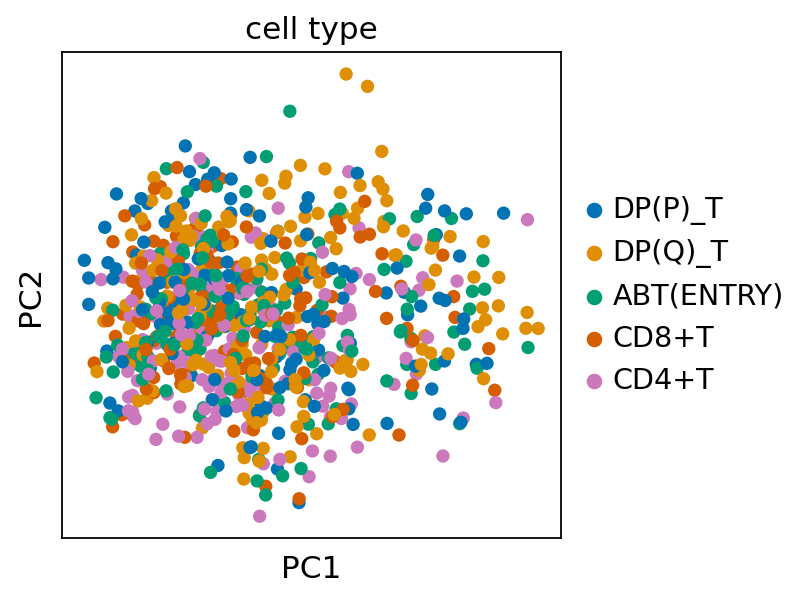

In [11]:
#use custom Chenqu colour map
ct_order = ['DP(P)_T','DP(Q)_T','ABT(ENTRY)','CD8+T','CD4+T']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette('colorblind'))[range(len(ct_order))]))

sc.pl.pca(bdata, color="anno_lvl_2_final_clean", title = 'cell type', palette = ct_color_map, save = 'conga.pdf')

Make a UMAP.

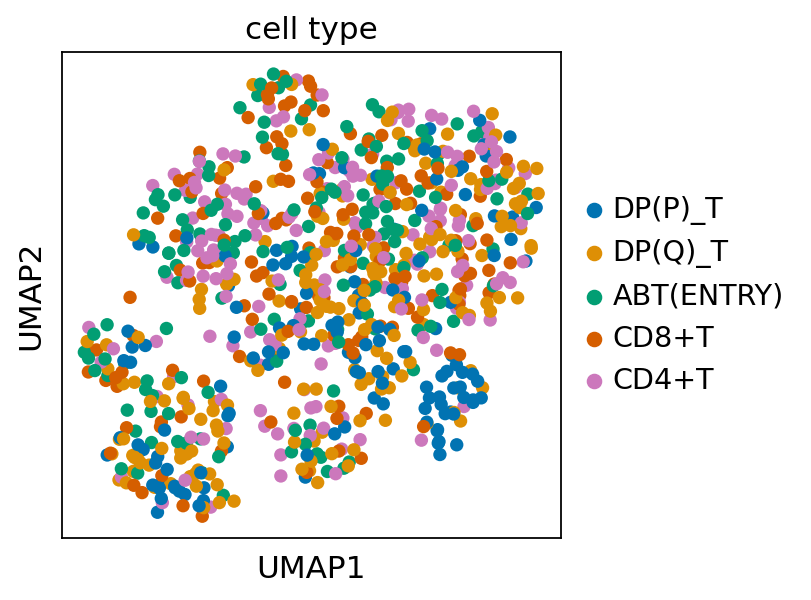

In [12]:
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)
sc.pl.umap(bdata, color="anno_lvl_2_final_clean", title = 'cell type', palette = ct_color_map, save = 'conga.pdf')

Save the object.

In [13]:
bdata.write("conga.h5ad")